In [1]:
import sys
sys.path.insert(0, '../../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

Need to do well by well GP analysis for high temps (above 37) or maybe for everything, and consider the distribution of growth rates. And use that to calculate errors of the errors? And finalize file names input and output, and pdfs to pngs, and error propogation of doubling time. Also, save time intervals used and reuse them for re analysis. potentially want to run several analysis in a row automatically, but prob too hard unless working with only glucose/delta files. 

save sets of instructions? and run script with the instructions changed as part of the script?
instructions: 
strain
carbon
full and subset plot parameters (start and end times)
GP parameters (start and end times)


also:
plate arrangement for each day
global glyph and color dictionary

In [34]:
data_dir = ''
growth_exp = glob.glob(f'{data_dir}*growth')
growth_dfs = []
for _, d in enumerate(growth_exp):
#    if int(d.split('_')[0]) > 20190210:
    if glob.glob(f'{d}/output/delta_glucose_GP_summary.csv') != []:
        growth_df = pd.read_csv(glob.glob(f'{d}/output/delta_glucose_GP_summary.csv')[0])
        growth_df['date'] = d.split('_')[0]
        growth_df['temp_C'] = d.split('_')[2][0:2]
        growth_dfs.append(growth_df)
growth_df = pd.concat(growth_dfs)
growth_df['carbon'] = 'glucose'
growth_df['operator'] = 'O2'
growth_df.to_csv('compiled_growth_summary.csv', index=False)

In [8]:
growth_df = pd.read_csv(f'./compiled_growth_summary.csv')

In [9]:
growth_df.head()

,parameter,value,date,temp_C,carbon,operator
0,max df,0.008157,20190213,42,glucose,O2
1,max df std,0.000048,20190213,42,glucose,O2
2,max df stderr,0.000005,20190213,42,glucose,O2
3,time of max df,507.856667,20190213,42,glucose,O2
4,time of max df std,7.411741,20190213,42,glucose,O2


In [18]:
# select the first derivative and standard deviation parameters
growth_rate_df = growth_df[
    (growth_df['parameter'] == 'max df') | (growth_df['parameter'] == 'max df std')].copy().reset_index(drop=True)
# rename
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df','parameter'] = 'growth_rate'
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df std','parameter'] = 'growth_rate_std'

In [46]:
# reshape
wide = growth_rate_df.pivot(index = 'date', columns='parameter', values='value').reset_index()
long = growth_rate_df[['date','temp_C','carbon','operator']].drop_duplicates()
stats_df = pd.merge(long,wide, how='left', on='date').sort_values('date')

In [47]:
# calculate doubling times and standard deviations from first derivative
stats_df['doub_time_minutes'] = np.log(2)/stats_df['growth_rate']
stats_df['doub_time_std'] = np.log(2)*stats_df['growth_rate_std']/(stats_df['growth_rate'])**2
stats_df

,date,temp_C,carbon,operator,growth_rate,growth_rate_std,doub_time_minutes,doub_time_std
5,20190124,37,glucose,O2,0.010165,0.000060,68.192387,0.399906
7,20190125,37,glucose,O2,0.010695,0.000082,64.808234,0.495594
1,20190128,37,glucose,O2,0.010125,0.000096,68.461892,0.650448
4,20190129,37,glucose,O2,0.010287,0.000070,67.383060,0.456531
6,20190130,37,glucose,O2,0.010262,0.000657,67.543437,4.322640
8,20190201,37,glucose,O2,0.009988,0.000074,69.399900,0.514974
3,20190212,32,glucose,O2,0.007529,0.000105,92.066691,1.288962
0,20190213,42,glucose,O2,0.008157,0.000048,84.973865,0.496458
2,20190220,27,glucose,O2,0.004319,0.000018,160.480579,0.669348


In [106]:
import matplotlib.ticker as mticker

In [49]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

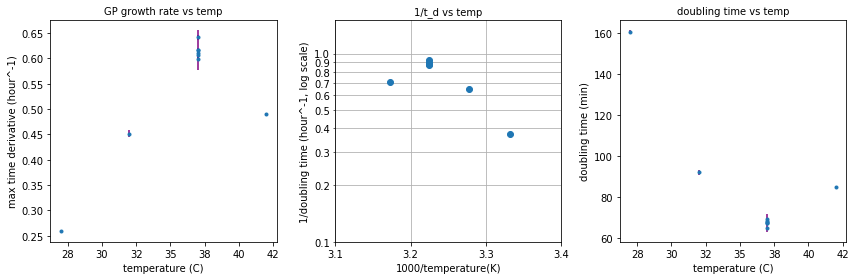

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title('GP growth rate vs temp', fontsize = 10)
ax[0].errorbar(stats_df['temp_C'], 60*stats_df['growth_rate'], yerr = 60*stats_df['growth_rate_std'],
              fmt = '.', ecolor = 'purple')
ax[0].set_xlabel('temperature (C)')
ax[0].set_ylabel('max time derivative (hour^-1)')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax[1].set_title('1/t_d vs temp', fontsize = 10)
ax[1].semilogy(1000/(stats_df['temp_C']+273.15), 60/stats_df['doub_time_minutes'], 'o')
ax[1].grid(True, which="both")
ax[1].set_yticks(np.arange(0.1,1.1,0.1), True)
ax[1].set_xticks(np.arange(3.1,3.5,0.1))
ax[1].set_ylim(0.1, 1.5)
ax[1].set_yticks([], False)
ax[1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].set_xlabel('1000/temperature(K)')
ax[1].set_ylabel('1/doubling time (hour^-1, log scale)')

ax[2].set_title('doubling time vs temp', fontsize=10)
ax[2].errorbar(stats_df['temp_C'], stats_df['doub_time_minutes'], yerr = stats_df['doub_time_std'],
               fmt = '.', ecolor = 'purple')
ax[2].set_xlabel('temperature (C)')
ax[2].set_ylabel('doubling time (min)')
ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.tight_layout()
#plt.savefig(f'delta_glucose_growth_rate_vs_temperature.png')

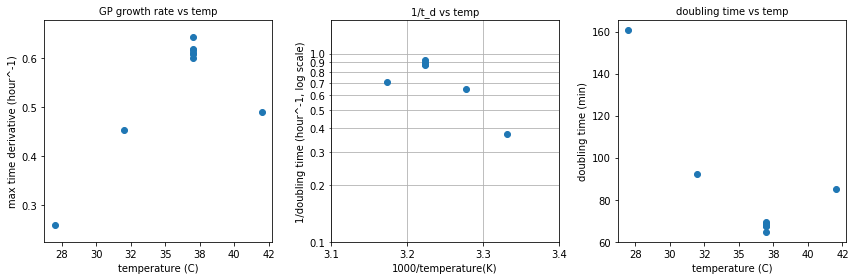

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].set_title('GP growth rate vs temp', fontsize = 10)
ax[0].scatter(growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['temp_C'], 
            60*growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['value'])
ax[0].set_xlabel('temperature (C)')
ax[0].set_ylabel('max time derivative (hour^-1)')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax[1].set_title('1/t_d vs temp', fontsize = 10)
ax[1].semilogy(1000/(growth_rate_df[growth_rate_df['parameter'] == 'growth_rate']['temp_C']+273.15), 
            60/growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['value'], 'o')
ax[1].grid(True, which="both")
ax[1].set_yticks(np.arange(0.1,1.1,0.1), True)
ax[1].set_xticks(np.arange(3.1,3.5,0.1))
ax[1].set_ylim(0.1, 1.5)
ax[1].set_yticks([], False)
ax[1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].set_xlabel('1000/temperature(K)')
ax[1].set_ylabel('1/doubling time (hour^-1, log scale)')

ax[2].set_title('doubling time vs temp', fontsize=10)
ax[2].errorbar(growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['temp_C'], 
            growth_rate_df[growth_rate_df['parameter'] == 'doubling_time']['value'], yerr = )
ax[2].set_xlabel('temperature (C)')
ax[2].set_ylabel('doubling time (min)')
ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
fig.tight_layout()
plt.savefig(f'delta_glucose_growth_rate_vs_temperature.png')

just in case

    def plotdoubtime(self, errorfac= 1, xlabel= 'time', ylabel= False, figtitle= False):
        '''
        Plots the results of the fit.

        Arguments
        --
        char: the type of fit to plot - 'f' or 'df' or 'ddf'
        errorfac: sets the size of the errorbars to be errorfac times the standard deviation
        ylabel: the y-axis label
        figtitle: the title of the figure
        '''
        x= getattr(self, 'df')
        xv= getattr(self, 'df' + 'var')
        dt= np.log(2)/x
        dtv= xv*(np.log(2)**2/(x**4))
        plt.plot(self.t, dt, 'b')
        plt.fill_between(self.t, dt-errorfac*np.sqrt(tdv), dt+errorfac*np.sqrt(tdv), facecolor= 'blue', alpha= 0.2)
        if ylabel:
            plt.ylabel(ylabel)
        else:
            plt.ylabel('dt')
        plt.xlabel(xlabel)
        if figtitle: plt.title(figtitle)